# Computing Truncated Joint Approximate Eigenbases for Model Order Reduction

### Code by: Fredy Vides

## Additional settings for Google Colab

In [1]:
#!pip install -U statsmodels

## Joint eigenbases computation function

In [2]:
#!/usr/bin/env python3
"""
Created on Sat Jan  1 18:04:52 2022
joint_diag approximate joint diagonalization method
   Code by Fredy Vides
   For Paper, "Quadratic pseudospectrum and optimal joint approximate eigenvectors"
   by T. Loring, F. Vides
@author: Fredy Vides

This code is based on the matlab program joint_diag.m by J.-F. Cardoso
"""

def joint_diag(A,jthresh):
    from numpy import array,zeros,identity,real,argsort,sqrt,conj
    from numpy.linalg import eig
    m = A.shape[0]
    nm = A.shape[1]
    A = A.astype(complex)
    B = array([[1,0,0],[0,1,1],[0,-1j,1j]])
    Bt = B.conj().T
    Ip = zeros((1,nm))
    Iq = zeros((1,nm))
    n = int(nm/m)
    g = zeros((3,n))
    g = g.astype(complex)
    G = zeros((2,2))
    vcp = zeros((3,3))
    D  = zeros((3,3))
    K = zeros((3,3))
    angles = zeros((3,1))
    pair = zeros((1,2))
    c = 0
    s = 0
    V = identity(m)
    V = V.astype(complex)
    encore	= 1
    while encore:
        encore=0
        for p in range(1,m):
            Ip = range(p-1,nm,m)
            for q in range(p+1,m+1):
                Iq = range(q-1,nm,m)
                g[0,:] = A[p-1,Ip]-A[q-1,Iq]
                g[1,:] = A[p-1,Iq]
                g[2,:] = A[q-1,Ip]
                D,vcp = eig(real(B@(g@g.conj().T)@Bt))
                K = argsort(D)
                angles  = vcp[:,K[2]]
                if angles[0]<0:
                    angles = -angles
                c = sqrt(0.5+angles[0]/2)
                s = 0.5*(angles[1]-1j*angles[2])/c
                if abs(s)>jthresh:
                    encore = 1
                    pair = array([p-1,q-1])
                    G = array([[c,-conj(s)],[s,c]])
                    V[:,pair] = V[:,pair]@G
                    A[pair,:] = G.conj().T @ A[pair,:]
                    AIp = A[:,Ip]
                    AIq = A[:,Iq]
                    A[:,Ip]=c*AIp+s*AIq
                    A[:,Iq]=-conj(s)*AIp+c*AIq
    D = A
    return V,D

## Truncated Joint Approximate Eigenbses Computation

In [3]:
#!/usr/bin/env python3
"""
Created on Sat Jan  1 18:04:52 2022
partial joint_diag approximate joint diagonalization method
   Code by Fredy Vides
   For Paper, "Quadratic pseudospectrum and optimal joint approximate eigenvectors"
   by T. Loring, F. Vides
@author: Fredy Vides

Code based on the Matlab program joint_diag.m by
 J. F. Cardoso
"""

def P_Joint_Diag(A,lambda0,sigma0,L,delta):
    from numpy import identity,kron
    from scipy.sparse.linalg import eigs
    from numpy.linalg import eig
    m = A.shape[0]
    mn = A.shape[1]
    n=int(mn/m)
    F=identity(m)
    A=A.astype(complex)
    A=A-kron(lambda0,F)
    C=A@A.conj().T
    C=(C+C.conj().T)/2
    E=identity(n)
    if L<(m-1):
        V=eigs(C,k=L, M=None, sigma=None, which=sigma0, v0=None, ncv=None, maxiter=None, tol=delta)[1]
    else:
        L=m
        V=eig(C)[1]
    C0=V.conj().T@A@kron(E,V)
    for j in range(n):
        D0=C0[:,j*L:(j+1)*L].astype(complex)
        D0=(D0+D0.conj().T)/2
        C0[:,j*L:(j+1)*L]=D0
    W = joint_diag(C0,delta)[0]
    V=V@W
    return V

## Data visualization function

In [4]:
def DataView(X,Y,S,idx):
    from matplotlib.pyplot import subplot,figure,plot,show
    from numpy import real,imag
    fig_0=figure(1)
    subplot(221)
    plot(X[idx[0],:]),plot(Y[idx[0],:],'r')
    subplot(222)
    plot(real(Y[idx[0],:]-X[idx[0],:]))
    subplot(223)
    plot(X[idx[1],:]),plot(Y[idx[1],:],'r')
    subplot(224)
    plot(real(Y[idx[1],:]-X[idx[1],:]))
    show()
    fig_1=figure(2)
    subplot(221)
    plot(real(S[idx[0],:]))
    subplot(222)
    plot(imag(S[idx[0],:]))
    subplot(223)
    plot(real(S[idx[1],:]))
    subplot(224)
    plot(imag(S[idx[1],:]))
    show()
    fig_0.savefig('fig_results_summary_0'+str(1)+'.png',dpi=600,format='png')
    fig_1.savefig('fig_results_summary_0'+str(2)+'.png',dpi=600,format='png')

## Cumulant estimate function

In [5]:
#!/usr/bin/env python3
"""
Created on Sat Jan  1 18:04:52 2022
partial joint_diag approximate joint diagonalization method
   Code by Fredy Vides
   For Paper, "Quadratic pseudospectrum and optimal joint approximate eigenvectors"
   by T. Loring, F. Vides
@author: Fredy Vides

Code based on the program jade.m
 by J.-F. Cardoso.
"""

def CumulantEstimate(X,m=0):
    from numpy import argsort,ones,sqrt,mean,zeros,reshape,conj,diag,dot
    from numpy.linalg import eig,inv
    from scipy.linalg import sqrtm
    n = X.shape[0]
    T = X.shape[1]
    if m==0:
        m=n
    nem = m
    if m<n:
        D,U = eig((X@X.conj().T)/T)
        k = argsort(D)
        puiss = D[k]
        ibl = sqrt(puiss[(n-m):n]-mean(puiss[0:(n-m)]))
        bl 	= ones(m)/ibl
        W	= diag(bl)@U[:,k[(n-m):n]].conj().T
        IW 	= U[:,k[(n-m):n]]@diag(ibl)
    else:
        IW 	= sqrtm((X@X.conj().T)/T)
        W	= inv(IW)
    Y = W@(X-reshape(mean(X,1),(n,1))@ones((1,T)))
    
    R	= (Y@Y.conj().T)/T
    C	= (Y@Y.T)/T
    
    Yl	= zeros((1,T))
    Ykl	= zeros((1,T))
    Yjkl = zeros((1,T))
    Q = zeros((m*m*m*m,1))
    Q = Q.astype(complex)
    index = 0
    
    for lx in range(m):
        Yl = Y[lx,:]
        for kx in range(m):
            Ykl = Yl*conj(Y[kx,:])
            for jx in range(m):
                Yjkl = Ykl*conj(Y[jx,:])
                for ix in range(m):
                    Q[index] = dot(Yjkl,Y[ix,:])/T -  R[ix,jx]*R[lx,kx] -  R[ix,kx]*R[lx,jx] -  C[ix,lx]*conj(C[jx,kx])
                    index = index + 1
                    
    D,U	= eig(reshape(Q,(m*m,m*m)).T)
    K = argsort(abs(D))
    la = D[K]
    
    C = zeros((m,nem*m))
    C = C.astype(complex)
    h	= m*m-1
    for u in range(0,nem*m,m):
        Z = reshape(U[:,K[h]],(m,m)).T
        C[:,u:(u+m)]	= la[h]*Z
        h = h-1
    
    return C,IW

## JAE based dimensionality reduction function

In [6]:
"""
Created on Sat Jan  1 18:04:52 2022
Dimensionality reduction methods based on partial joint_diag approximate joint 
diagonalization method

   Code by Fredy Vides
   For Paper, "Quadratic pseudospectrum and optimal joint approximate eigenvectors"
   by T. Loring, F. Vides
@author: Fredy Vides

Code based on the program jade.m
 by J.-F. Cardoso.
"""
def drJADE(X,m,L,tol):
    from numpy import reshape,zeros,mean,ones
    from numpy.linalg import lstsq
    from time import time
    start = time()
    C,IW=CumulantEstimate(X,m)
    end=time()
    print("Cumulant estimate runtime: ",end-start)
    start = time()
    V=P_Joint_Diag(C,zeros((1,m)),'LM',L,tol)
    end = time()
    print("Approximate joint diagonalization runtime: ",end-start)
    Sr = V.conj().T@lstsq(IW,X,rcond=None)[0]
    T = reshape(mean(X,1),(X.shape[0],1))@ones((1,X.shape[1]))
    Xr = IW@V@Sr+T
    return X,T,Xr,Sr,C,IW,V

## Synthetic Signal Generator

In [7]:
# Example: X=SyntheticSignals(1e-1)
def SyntheticSignals(noise):
    from numpy import sin,cos,reshape,linspace,pi,zeros
    from numpy.random import randn
    t = linspace(0,30,15000)
    X = reshape(range(10),(10,1))@reshape(t,(1,15000))
    Y = zeros((50,15000))
    Y[:10,:] = sin(pi*X)
    Y[10:20,:] = cos(pi*X)
    Y[20:30,:] = sin(pi*(X+20))
    Y[30:40,:] = cos(pi*(X+20))
    Y[40:44,:] = sin(pi*(X[:4,:]+10))
    Y[44:48,:] = cos(pi*(X[:4,:]+10))
    Y[48:,:] = noise*randn(2,15000)
    A=zeros((50,50))
    A[:,:5] = randn(50,5)
    A[:,5:10] = noise*randn(50,5)
    A[:,10:15] = randn(50,5)
    A[:,15:20] = noise*randn(50,5)
    A[:,20:23] = randn(50,3)
    A[:,23:25] = noise*randn(50,2)
    A[:,25:27] = randn(50,2)
    A[:,27:] = randn(50,23)*noise
    X = A@Y
    return X

## Sparse linear least squares solver

In [8]:
#!/usr/bin/env python3
"""
Created on Wed Mar 31 02:57:52 2021
LSSPSOLVER  Sparse linear least squares solver
   Code by Fredy Vides
   For Paper, "Computing Sparse Semilinear Models for Approximately Eventually Periodic Signals"
   by F. Vides
@author: Fredy Vides
"""

def lsspsolver(A,Y,L=100,tol=1e-2,delta=1e-2):
    from numpy.linalg import svd,lstsq,norm
    from numpy import zeros,dot,diag,argsort,inf
    N=A.shape[1]
    X=zeros((N,))
    u,s,v=svd(A,full_matrices=0)
    rk=sum(s>tol)
    u=u[:,:rk]
    s=s[:rk]
    s=1/s
    s=diag(s)
    v=v[:rk,:]
    A=dot(u.conj().T,A)
    Y=dot(u.conj().T,Y)
    X0=dot(v.conj().T,dot(s,Y))
    w=zeros((N,))
    K=1
    Error=1+tol
    c=X0
    x0=c
    ac=abs(c)
    f=argsort(-ac)
    N0=max(sum(ac[f]>delta),1)
    while (K<=L) & (Error>tol):
        ff=f[:N0]
        X=w
        c = lstsq(A[:,ff],Y,rcond=None)[0]
        X[ff]=c
        Error=norm(x0-X[:],inf)
        x0=X
        ac=abs(x0)
        f=argsort(-ac)
        N0=max(sum(ac[f]>delta),1)
        K=K+1
    return X

## Sparse Autoregressor

In [9]:
#!/usr/bin/env python3
"""
Created on Wed Mar 31 02:57:52 2021
SPAUTOREGRESSOR  Sparse autoregressor for time series modeling
   Code by Fredy Vides
   For Paper, "Computing Sparse Semilinear Models for Approximately 
   Eventually Periodic Signals"
   by F. Vides
@author: Fredy Vides
"""
def SpAutoRegressor(x,ssp,sp,pp,L0,tol,delta):
    from numpy import ceil,floor,max,min
    from scipy.linalg import hankel
    sl = len(x)
    ssp=int(ceil(sl*ssp))
    x = x[0:sl:ssp]
    sl = len(x)
    sp = int(ceil(sp*sl))
    xt = x[:sp]
    pp = max([min([floor(pp*sp),sl-sp]),L0])
    L=L0
    H=hankel(xt[:L],xt[(L-1):])
    H0=H[:,:-1]
    H1=H[-1,1:]
    A = lsspsolver(H0.T,H1.T,L,tol,delta)
    return A.T,H0[:,0]   

## Sparse predictor

In [10]:
#!/usr/bin/env python3
"""
Created on Wed Mar 31 02:57:52 2021
SPARPREDICTOR  Sparse AR predictor for time series modeling
   Code by Fredy Vides
   For Paper, "Computing Sparse Semilinear Models for Approximately Eventually Periodic Signals"
   by F. Vides
@author: Fredy Vides
"""

def SPARPredictor(A,h,N):
    from numpy import append
    y=h
    L = len(h)
    for k in range(N):
        y = append(y,A.dot(h))
        h = y[k+1:L+k+1]
    return y

## Lag Estimate Function

In [11]:
#!/usr/bin/env python3
"""
Created on Wed Mar 31 02:57:52 2021
LAGESTIMATE ACF-FFT based sparse lag estimator
   Code by Fredy Vides
   For Paper, "Computing Sparse Semilinear Models for Approximately Eventually Periodic Signals"
   by F. Vides
@author: Fredy Vides
"""
def LagEstimate(data,L0):
    from statsmodels.tsa.stattools import acf 
    from scipy.signal import find_peaks
    from numpy import where
    L = acf(data,adjusted=False,nlags=len(data),fft=True)
    p = find_peaks(L)
    if len(p[0])>0:
        q=where(L[p[0]]==L[p[0]].max())
        L = max(p[0][q[0][0]],L0)
    else:
        L = L0
    return L

## SpAR Model Computation Function

In [12]:
def SpARModelComputation(xs,sampling_proportion,Lag,delta,tol):
    r = []
    A,h_0 = SpAutoRegressor(xs,1/len(xs),sampling_proportion,1,Lag,delta,tol)
    r.append(A)
    r.append(h_0)
    return r

## Source Model Computation

In [13]:
# %load SourceModel.py
#!/usr/bin/env python3
"""
Created on Fri Jan  7 18:15:28 2022
SOURCEMODEL Source model computation using JAD based model order 
    reduction technology
    Code by Fredy Vides
    For Paper, "Computing Truncated Joint Approximate Eigenbases for 
    Model Order Reduction"
    by T. Loring, F. Vides
@author: Fredy Vides
"""

def ParSourceModel(Sr,idx,sampling_proportion,delta,tol):
    from numpy import real,imag,zeros
    from time import time
    from multiprocessing import Pool
    
    data = Sr[idx[0]:idx[1],:]
    N = data.shape[0]
    Ld = data.shape[1]
    
    Sp = zeros((N,Ld))
    Sp = Sp.astype(complex)
    
    Lags = []
    steps = []
    Mdr =  []
    Mdi = []
    mdr = []
    mdi = []
    
    start = time()
    RModelData = []
    IModelData = []
    for k in range(N):
        Lag = LagEstimate(real(data[k,:].copy()),10)
        steps.append(Ld-Lag)
        Lags.append(Lag)
        
        xr = real(data[k,:].copy())
        xi = imag(data[k,:].copy())
        mdr0 = xr.min()
        mdi0 = xi.min()
        Mdr0 = abs(xr - mdr0).max()
        Mdi0 = abs(xi - mdi0).max()
        
        Mdr.append(Mdr0)
        mdr.append(mdr0)
        Mdi.append(Mdi0)
        mdi.append(mdi0)
        
        xsr = 2*(xr-mdr0)/Mdr0-1
        xsi = 2*(xi-mdi0)/Mdi0-1
        
        RModelData.append((xsr,sampling_proportion,Lag,delta,tol))
        IModelData.append((xsi,sampling_proportion,Lag,delta,tol))
    print("Model data generation elapsed time: ",time()-start)
    
    start = time()
    with Pool(8) as p:
        RModel = p.starmap(SpARModelComputation, RModelData)
        IModel = p.starmap(SpARModelComputation, IModelData)
    print("Model computation elapsed time: ",time()-start)
    
    start = time()
    for k in range(N):
        yr = Mdr[k]*(SPARPredictor(RModel[k][0],RModel[k][1],steps[k])+1)/2+mdr[k]
        yi = Mdi[k]*(SPARPredictor(IModel[k][0],IModel[k][1],steps[k])+1)/2+mdi[k]
        Sp[k,:] = yr + 1j*yi
    print("Signal reconstruction elapsed time: ",time()-start)
    
    return Lags,RModel,IModel,Sp

## Randomness Test Function

In [14]:
def ErrorRandomnessTest(idx,X,Xp):
    from matplotlib.pyplot import hist,subplot,figure
    from scipy.stats import normaltest
    from numpy import real
    from randtest import random_score
    Noise = real(X[idx[0],:]-Xp[idx[0],:])
    k1,p0 = normaltest(Noise)
    fig_0 = figure(1)
    subplot(211)
    h0 = hist(Noise,bins=30,density=1,alpha=0.6, color='b')
    print('Randomness test result: ',random_score(Noise))
    print('Normality test p-value: ',p0)
    Noise = real(X[idx[1],:]-Xp[idx[1],:])
    k1,p0 = normaltest(Noise)
    subplot(212)
    h0 = hist(Noise,bins=30,density=1,alpha=0.6, color='b')
    print('Randomness test result: ',random_score(Noise))
    print('Normality test p-value: ',p0)
    fig_0.savefig('fig_results_summary_0'+str(3)+'.png',dpi=600,format='png')

## Time Series Model Order Reduction Example

Cumulant estimate runtime:  5.4398205280303955
Approximate joint diagonalization runtime:  0.23712515830993652
Model data generation elapsed time:  0.24011611938476562
Model computation elapsed time:  48.65032625198364
Signal reconstruction elapsed time:  4.342466592788696


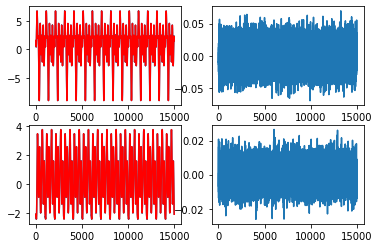

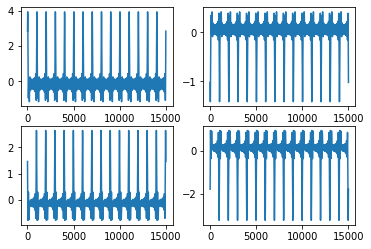

Testing randomness of some noises.
Randomness test result:  True
Normality test p-value:  0.47507010316958953
Randomness test result:  True
Normality test p-value:  0.7097846482367024


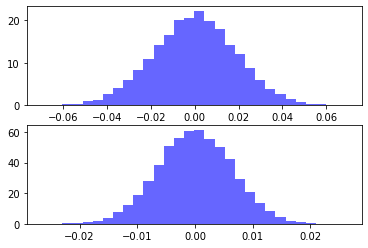

In [15]:
select = 0
idx = [0,1]
from pandas import read_csv
from numpy import real
if select == 0:
    url = "https://raw.githubusercontent.com/FredyVides/PyTJAE/master/DataSets/X.csv"
    X = read_csv(url,header=None).values
else:
    X = SyntheticSignals(1e-1)
X,T,Xr,Sr,C,IW,V=drJADE(X,22,18,1e-2)
Lags,Ar,Ai,Sp = ParSourceModel(Sr,[0,Sr.shape[0]],0.15,1e-1,1e-3)
Xp = IW@V@Sp+T
DataView(X,real(Xp),Sp,idx)
print("Testing randomness of some noises.")
ErrorRandomnessTest(idx,X,Xp)

## References

1. T. Loring, F. Vides. Computing Truncated Joint Approximate Eigenbases for Model Order Reduction.